# Gaussian Mixture Models

## Definition

"A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians."

Source: [Sci-Kit-Learn Documentation](https://scikit-learn.org/stable/modules/mixture.html), accessed November 27, 2020

"Gaussian mixture models are a probabilistic model for representing normally distributed subpopulations within an overall population. Mixture models in general don't require knowing which subpopulation a data point belongs to, allowing the model to learn the subpopulations automatically. Since subpopulation assignment is not known, this constitutes a form of unsupervised learning."

Source: [Brilliant.org-Wiki: Gaussian Mixture Model](https://brilliant.org/wiki/gaussian-mixture-model/), accessed November 27, 2020

_Or more formaly:_

A _Gaussian Mixture_ is a function that combines multiple Gaussians (normal distributions in the classic bell curve), each identified by $k \in \{ 1, \dots, K \}$ where $K$ is the number of clusters of our dataset. Each Gaussian $k$ in the mixture is comprised of the following parameters:

* the mean $\mu$ that defines the center of the distribution
* the covariance $\Sigma$ defining the width of the distribution (for a single normal distribution this is equivalent to the standard deviation $\sigma$) 
* a mixing probability $\pi$ defining how big or small the Gaussian function will be


### The Normal Distribution

The normal (gaussian) distribution's _probability density function_ **(PDF)** is defined as follows:

$$ f(x|\mu, \sigma)= \frac{1}{\sqrt{2\mu\sigma}} exp \bigg(-\frac{(x-\mu)^2}{2\sigma^2}\bigg) $$

In [3]:
# implementing a funtion for creating a single normal distribution
import math

SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float=0, sigma: float=1) -> float:
    return math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma)

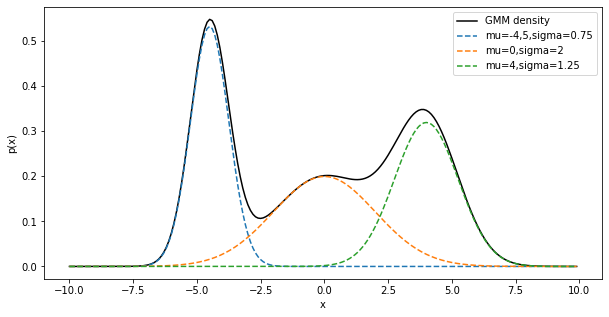

In [65]:
# lets plot some pdfs
import matplotlib.pyplot as plt
import numpy as np
# points xs ranging from -5 to 5
xs = [x / 10.0 for x in range(-100, 100)]
# actual plot
plt.figure(figsize=(10, 5))

first = [normal_pdf(x,sigma=0.75, mu=-4.5) for x in xs]
second = [normal_pdf(x,sigma=2, mu=0) for x in xs]
third = [normal_pdf(x,sigma=1.25, mu=4) for x in xs]

weights = np.array([16, 4, 12])

combination = np.array([first, second, third])

gmm_naive = np.sum(combination, axis=0)

plt.plot(xs, gmm_naive, '-', label='GMM density', color='k')

plt.plot(xs, first,'--',label='mu=-4,5,sigma=0.75', color='tab:blue')
plt.plot(xs, second,'--',label='mu=0,sigma=2', color='tab:orange')
plt.plot(xs, third,'--',label='mu=4,sigma=1.25', color='tab:green')
plt.legend()
plt.ylabel('p(x)')
plt.xlabel('x')
plt.show()

![Different Gaussian Distributions](gaussian_distributions.png)

### GMM as Clustering Algorithm

#### Motivation: Weaknesses of k-Means

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the **k-means model has no intrinsic measure of probability or uncertainty of cluster assignments**. For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.

Source: [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html), accessed November 27, 2020

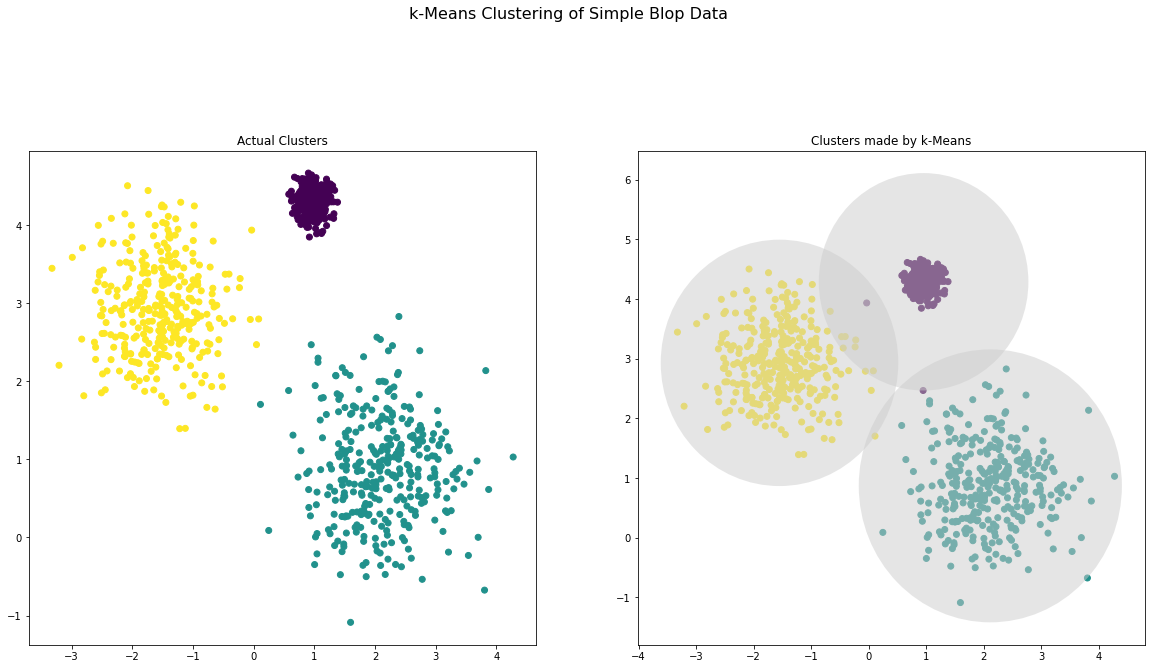

In [122]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import numpy as np

def get_radii(X, y, centers):
    return [cdist(X[y == i], [center], 'euclidean').max()
         for i, center in enumerate(centers)]


def plot_kmeans(pos, title, kmeans, X, y, print_radius=False):
    plt.subplot(pos)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if print_radius:
        centers = kmeans.cluster_centers_
        radii = get_radii(X, y, centers)
        for c, r in zip(centers, radii):
            circle=plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1)
            plt.gca().add_patch(circle)
    plt.title(title)

    
plt.figure(figsize=(20, 20))

random_state = 0

X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=random_state, cluster_std=[0.15, 0.7, 0.6])

kmeans = KMeans(n_clusters=3, random_state=random_state)

y_pred = kmeans.fit_predict(X)

plot_kmeans((221), 'Actual Clusters', kmeans, X, y)

plot_kmeans((222), 'Clusters made by k-Means', kmeans, X, y_pred, print_radius=True)

plt.suptitle('k-Means Clustering of Simple Blop Data', fontsize=16)
plt.show()

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. If we take the same data and apply a transformation that drags it into a certain direction, we get clusters in elliptical form. In practice, such data is often obtained by looking at the properties of materials. If, for example, the splittability, elasticity, hardness and length changes (drying, heat) of wood are observed, the directional dependence (anisotropy) of the corresponding physical processes can be seen.

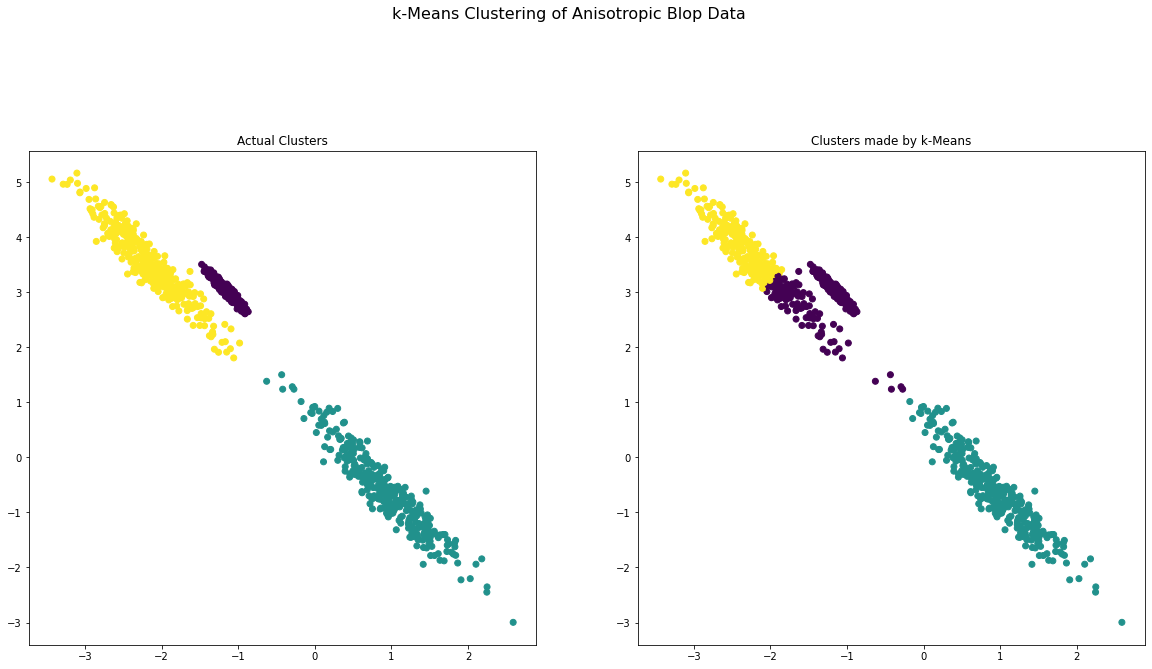

In [123]:
plt.figure(figsize=(20, 20))

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred_aniso = KMeans(n_clusters=3, random_state=0).fit_predict(X_aniso)


plot_kmeans((221), 'Actual Clusters', kmeans, X_aniso, y)

plot_kmeans((222), 'Clusters made by k-Means', kmeans, X_aniso, y_pred_aniso)


plt.suptitle('k-Means Clustering of Anisotropic Blop Data', fontsize=16)
plt.show()

#### Generalizing the concept of k-Means

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap.

You might imagine addressing these weaknesses by generalizing the k-means model: 

* for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. 

* You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. 

It turns out these are two essential components of a different type of clustering model, _Gaussian mixture models_.

#### Example Clustering on Blop Data

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means. But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments. We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction.

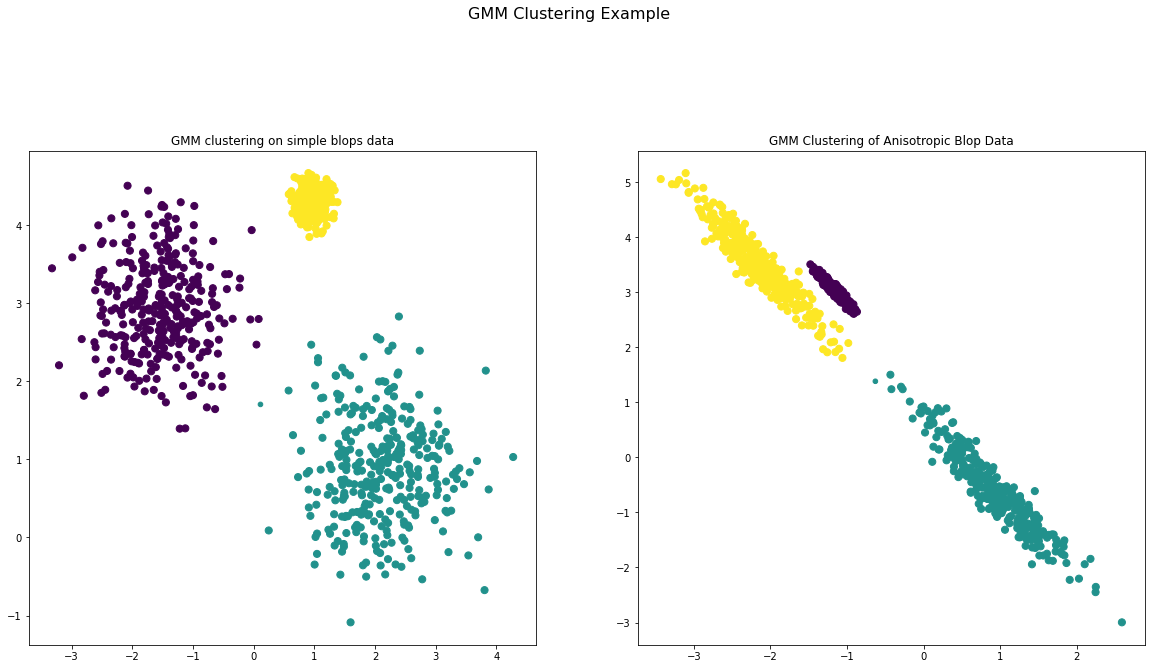

In [127]:
from sklearn.mixture import GaussianMixture



def plot_gmm(pos, title, X, n_components):
    plt.subplot(pos)
    gmm = GaussianMixture(n_components=n_components).fit(X)
    y_pred_gmm = gmm.predict(X)
    probs = gmm.predict_proba(X)
    size = 50 * probs.max(1) ** 2
    plt.scatter(X[:, 0], X[:, 1], c=y_pred_gmm, cmap='viridis', s=size)
    plt.title(title)
    
plt.figure(figsize=(20, 20))

plot_gmm((221), 'GMM clustering on simple blops data', X, 3)

plot_gmm((222), 'GMM Clustering of Anisotropic Blop Data', X_aniso, 3)

plt.suptitle('GMM Clustering Example', fontsize=16)
plt.show()



#### Learning the GMM

##### EM for Gaussian Mixture Models



### GMM as Density Estimation
"Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a **generative probabilistic model describing the distribution of the data**."

Source: [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html), accessed November 27, 2020

In [133]:
# load the datasets
import pandas as pd
state = 1337
num_samples = 20000

caida = pd.read_csv('caida_train.csv')
caida_benign_samples = caida[caida.label == 0].sample(n=num_samples, random_state=state)
caida_attack_samples = caida[caida.label == 1].sample(n=num_samples, random_state=state)

cicddos = pd.read_csv('cicddos_transformed.csv')
cicddos_benign_samples = cicddos[cicddos.label == 0].sample(n=num_samples, random_state=state)
cicddos_attack_samples = cicddos[cicddos.label == 1].sample(n=num_samples, random_state=state)

cicids = pd.read_csv('cicids2017_transformed.csv')
cicids_benign_samples = cicids[cicids.label == 0].sample(n=num_samples, random_state=state)
cicids_attack_samples = cicids[cicids.label == 1].sample(n=num_samples, random_state=state)

In [135]:
# normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

caida_benign_samples = pd.DataFrame(scaler.fit_transform(caida_benign_samples), columns=caida_benign_samples.columns)
caida_attack_samples = pd.DataFrame(scaler.fit_transform(caida_attack_samples), columns=caida_attack_samples.columns)

cicddos_benign_samples = pd.DataFrame(scaler.fit_transform(cicddos_benign_samples), columns=cicddos_benign_samples.columns)
cicddos_attack_samples = pd.DataFrame(scaler.fit_transform(cicddos_attack_samples), columns=cicddos_attack_samples.columns)

cicids_benign_samples = pd.DataFrame(scaler.fit_transform(cicids_benign_samples), columns=cicids_benign_samples.columns)
cicids_attack_samples = pd.DataFrame(scaler.fit_transform(cicids_attack_samples), columns=cicids_attack_samples.columns)

In [197]:
from sklearn.decomposition import PCA
pca_cicddos_benign = PCA(0.99)
cicddos_benign_pca = pca_cicddos_benign.fit_transform(cicddos_benign_samples.iloc[:, :-1])


pca_cicddos_attack = PCA(0.99)
cicddos_attack_pca = pca_cicddos_attack.fit_transform(cicddos_attack_samples.iloc[:, :-1])



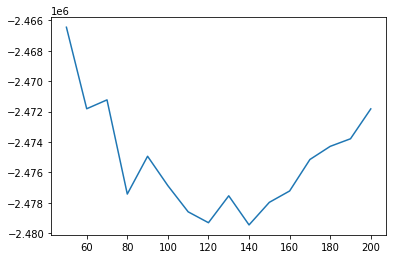

In [165]:


n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(cicddos_benign_pca).aic(cicddos_benign_pca) for model in models]
plt.plot(n_components, aics);



In [198]:
cicddos_benign_gmm = GaussianMixture(140, covariance_type='full', random_state=0)
cicddos_benign_gmm.fit(cicddos_benign_pca)
print(cicddos_benign_gmm.converged_)

True


In [199]:
cicddos_benign_new_samples_pca = cicddos_benign_gmm.sample(20000)[0]
cicddos_benign_new_samples = pca_cicddos_benign.inverse_transform(cicddos_benign_new_samples_pca)
print(cicddos_benign_new_samples_pca[:,-1])


[ 2.62587193e-05 -7.27093527e-05 -1.51316498e-03 ... -8.76723162e-03
 -4.88275037e-01 -4.87524916e-01]


In [ ]:
from sdv.evaluation import evaluate

X_train = cicddos_benign_new_samples
print(type(X_train))
X_test = cicddos_benign_samples.iloc[:, :-1]


evaluation = evaluate(cicddos_benign_samples, cicddos_benign_samples, metrics=['kstest', 'logistic_detection', 'svc_detection'])
print(evaluation)

In [182]:
# now make a visualization for comparing the data
# then make a comparison, if training a classifier works with synthetic data and tests well on original data!
# then test, if a classifier gets even more robust by adding synthetic data!
# then make slides for this notebook


from sklearn.neighbors import KernelDensity




# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='epanechnikov', metric='mahalanobis', metric_params={'V':np.cov(X_train)})
kde.fit(X_train)

# score_samples returns the log of the probability density
logprob = kde.score_samples(caida_benign_samples)

plt.fill_between(caida_benign_samples, np.exp(logprob), alpha=0.5)
plt.plot(cicddos_benign_new_samples, np.full_like(cicddos_benign_new_samples, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)


KeyboardInterrupt: 